# Dimension Reduction


The goal of this notebook is to illustrate dimension reduction on macroeconomic data.

Specifically, we will aim to identify the principal components from the FRED-MD macroeconomic dataset.

Literature:

Sargent & Sims (1977) "Business cycle modeling without pretending to have too much a priori economic theory" show that a small number of latent factors explains a large proportion of the variance in U.S. macroeconomic indicators.

Bai (2008) and Stock and Watson (2006) provide surveys of this literature.



---



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

### 1. $\quad$ Data

We'll use a function to download the FRED-MD dataset directly from the FRED website.

Alternatively, the data can be manually downloaded here:

https://www.stlouisfed.org/research/economists/mccracken/fred-databases

#### 1.1. $\quad$ Data download


In [3]:
# Retrieve the data
def load_data(fred_path: str):
    """
    Function to load data from FRED.

    Args:
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    df: Loaded dataset
    tcodes: Transformation codes
    """
    
    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path)[:-3]
    print("Done")

    tcodes = df.iloc[0, 1:]  # data tickers
    df.drop(0, inplace=True) # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df, tcodes


In [4]:
# Define paths for the dataset
fred_path = 'https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/2025-07-md.csv?sc_lang=en&hash=A1E7A098FEFE58C453870371DB34E6AF'

# Load the data
df, tcodes = load_data(fred_path)

df

Be patient: loading from FRED (2 minutes)
Done


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,17689.23968,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,17819.01912,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,17967.91336,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,17978.97983,23.1981,24.1903,22.8957,32.4019,19.5466,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18119.82573,23.5476,24.3911,23.1161,32.5567,19.9445,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,20126.456,16412.1,122.396,1.545040e+06,712145.00000,101.9503,99.3545,98.8365,100.8370,102.2327,...,119.230,129.380,31.59,36.26,28.22,71.8,556011.41,938335.20,5381.7462,15.9822
2024-12-01,20148.534,16434.6,123.077,1.558008e+06,717662.00000,103.0447,100.4234,99.9346,101.6683,100.6563,...,119.746,129.875,31.72,36.43,28.33,74.0,559364.75,943484.76,5366.3388,15.6997
2025-01-01,20181.340,16430.3,122.386,1.542895e+06,711461.00000,102.8805,100.6125,100.1338,101.5923,98.5588,...,120.458,130.293,31.91,36.56,28.58,71.7,559708.93,944674.17,5351.9157,16.8122


#### 1.2. $\quad$ Data pre-processing



##### Transform the Data



In [6]:
def transxf(x, tcode):
    """
    DESCRIPTION:
    This function transforms a single series (in a column vector)
    as specified by a given transformation code.

    INPUT:
        x      : Series (in a column vector) to be transformed
        tcode  : Transformation code (1-7)

    OUTPUT:
        result : Transformed series (as a column vector)

    """
    # Number of observations (including missing values)
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result to ensure it's always defined
    result = np.nan * np.ones(n)

    # Transformation logic
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result


In [8]:
yt = []             # Initialize output variable
N = df.shape[1]     # Number of series kept

for i in range(N):
    dum = transxf(df.iloc[:, i].values, tcodes[i])
    yt.append(dum)

transformed_data = pd.DataFrame(yt).T
transformed_data.columns = df.columns
transformed_data.index = df.index

transformed_data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.003877,0.003621,0.010349,0.007336,0.007310,0.019395,0.013405,0.008628,0.007309,0.005232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.006457,0.007325,0.009404,-0.003374,0.008321,0.014300,0.006036,0.004896,0.000000,0.019397,...,-0.001148,0.000292,-0.000022,-0.008147,0.004819,NaN,0.004929,0.004138,-0.014792,NaN
1959-04-01,0.006510,0.007029,-0.003622,0.019915,0.000616,0.021080,0.014339,0.014545,0.015652,0.006379,...,0.001312,0.001760,-0.000022,0.012203,-0.004890,NaN,0.012134,0.006734,0.024929,NaN
1959-05-01,0.005796,0.006618,0.012043,0.006839,0.007803,0.014954,0.008267,0.009580,0.004766,0.020152,...,-0.001695,-0.001867,-0.000021,-0.004090,-0.004819,NaN,0.002828,0.002020,-0.015342,NaN


##### Standardize the Data

In [9]:
"""
Many macroeconomic indicators in the FRED-MD dataset (e.g., interest rates, employment figures, and stock indices) have vastly different scales.
Without standardization, variables with larger numerical values may exert disproportionate influence on the PCA.
"""

# Drop NaNs generated by transformations
transformed_data.dropna(inplace=True)

# Standardize the transformed data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(transformed_data), columns=transformed_data.columns, index=transformed_data.index)

df_scaled.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1992-03-01,-0.039169,-0.227627,-0.096953,0.210601,-0.561181,0.867871,0.914977,0.846064,0.873319,0.603579,...,0.176519,-0.108740,0.293920,2.042513,-1.033034,1.796867,-0.549831,0.057928,-0.341386,-0.437566
1992-04-01,0.103505,0.057994,-0.260518,0.498164,0.329769,0.774220,0.798863,0.701583,0.922128,0.542904,...,-0.279698,0.499199,0.291695,-1.023167,0.505792,0.296841,1.258584,-0.197068,0.117227,-0.441817
1992-05-01,0.211174,0.456968,0.449540,-1.186631,-0.026726,0.212998,0.553653,0.519073,0.620410,0.960526,...,0.133205,-1.605799,-0.886756,-0.128407,-0.261219,0.496844,-1.788875,0.008448,0.355332,-0.623352
1992-06-01,0.135898,0.308702,0.046081,0.919309,0.061543,-0.136315,-0.470537,-0.497371,-0.619779,-0.541338,...,0.431761,0.170137,0.880210,1.392238,-0.259193,0.296841,1.545234,0.300774,-0.083782,-0.620233
1992-07-01,-0.197537,-0.521225,0.146955,1.227814,0.500406,0.950210,1.146631,1.149184,1.343807,0.805630,...,-0.308452,1.648128,-1.469837,-2.660885,-0.004415,-0.953181,-0.117177,-0.288800,0.197738,-0.800401


### 2. $\quad$ Principal Components

#### 2.1. $\quad$ Estimating the PC's

In [12]:
pca = PCA(n_components=20, whiten=True, svd_solver='full', random_state=42)
pca.fit(df_scaled)

PCA(n_components=20, random_state=42, svd_solver='full', whiten=True)

#### 2.2. $\quad$ Selecting the number of PCs to keep

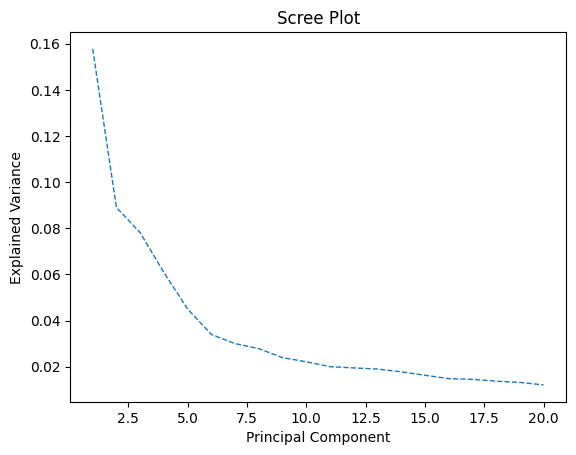

In [13]:
plt.figure()
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, '--', linewidth=1)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

plt.show()

In [21]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Decide on the number of components (e.g., explaining 75% variance)
n_components = np.argmax(cumulative_variance >= 0.50) + 1
print(f'Number of components explaining 50% of the variance: {n_components}')

Number of components explaining 50% of the variance: 8


#### 2.3. $\quad$ The final PCs

In [22]:
pca_indices = pd.DataFrame(pca.transform(df_scaled), index=df_scaled.index)
pca_indices

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sasdate,,,,,,,,,,,,,,,,,,,,
1992-03-01,0.535714,0.161777,-0.898328,1.071792,-1.575390,-0.815696,-0.013212,-0.583769,0.112018,0.400298,-0.287555,1.221832,0.648449,0.297074,-0.757441,-0.492277,0.875804,0.268422,-0.025948,0.228622
1992-04-01,0.113989,0.439209,-0.920818,-0.462463,-0.435170,-0.254096,-1.114757,-0.359490,1.025183,0.979545,0.454194,-0.407687,-0.430558,0.432405,-0.307540,-0.364465,-0.396788,0.687647,-0.546663,-1.011026
1992-05-01,0.009576,0.479915,-0.581800,-0.393097,-0.537992,0.088347,-1.090949,0.563784,-0.810961,0.296199,0.596919,-0.117154,0.471661,-0.258378,-0.289783,-0.597894,0.612761,-0.094933,-1.125356,-0.888983
1992-06-01,-0.252567,0.600864,-0.477824,0.041197,-0.559041,-0.027623,-1.336715,0.702023,-0.570165,-0.332196,-0.573543,-0.979140,0.449060,-0.146320,0.518766,-1.333860,-0.800828,0.604762,0.920811,-0.451664
1992-07-01,-0.100081,0.656260,-0.802136,-1.804815,-0.206155,-0.187372,-2.275766,-0.056430,0.885058,1.310300,0.661125,-1.868960,-0.552818,0.389851,-0.476991,1.283131,0.101140,0.203002,-0.431856,0.167573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,0.023811,-0.160067,0.534239,-0.023964,0.169952,-0.197676,1.854960,-0.880261,-1.128111,0.063551,0.113712,0.842407,1.026382,0.102796,-0.821011,-1.033675,-0.205881,-1.224700,-0.543057,0.664068
2024-12-01,0.535948,0.143374,0.485891,-0.751625,-0.073981,-0.562901,0.858174,-1.114472,0.487187,-0.084826,0.880214,0.751088,-1.794434,0.003573,0.704183,-0.041517,0.811637,0.869604,0.876365,-0.488520
2025-01-01,-0.145790,-0.017614,0.752934,0.272053,0.454767,-0.351684,1.335724,0.421825,1.217871,0.335193,0.116032,1.728136,0.671385,1.756324,0.609869,0.723460,-1.999445,0.446585,-0.827060,0.819183


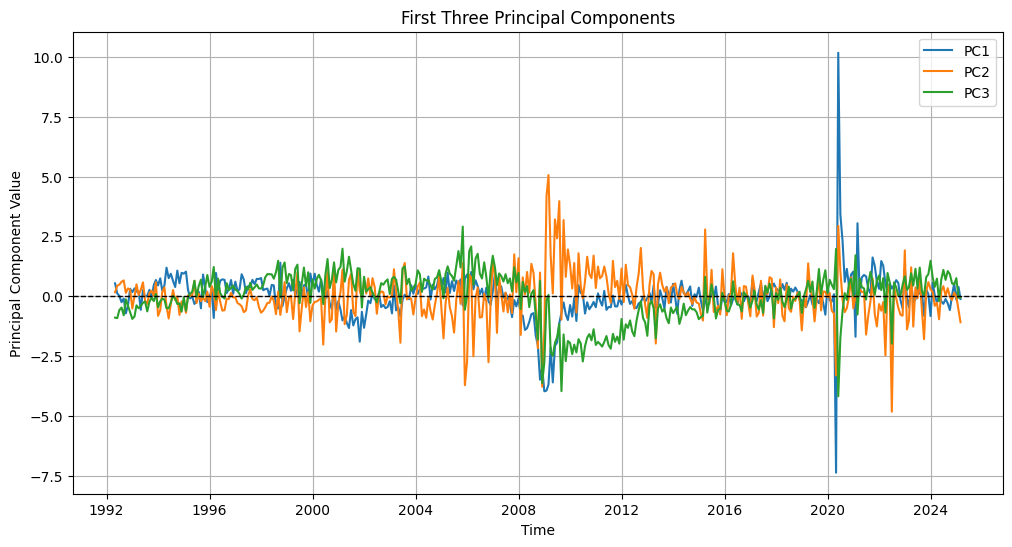

In [23]:
columns = []
for _ in np.arange(pca.n_components_) + 1:
    pc_name = "PC"+str(_)
    columns.append(pc_name)

pca_indices.columns = columns

# Plot the first three principal components
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(pca_indices):], pca_indices["PC1"], label="PC1")
plt.plot(df.index[-len(pca_indices):], pca_indices["PC2"], label="PC2")
plt.plot(df.index[-len(pca_indices):], pca_indices["PC3"], label="PC3")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a reference line
plt.legend()
plt.title("First Three Principal Components")
plt.xlabel("Time")
plt.ylabel("Principal Component Value")
plt.grid(True)
plt.show()

In [24]:
pca_loadings = pd.DataFrame(pca.components_.T, index=df_scaled.columns.values)
pca_loadings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
RPI,0.041334,-0.029809,-0.027486,-0.027369,-0.029297,-0.039594,-0.013311,-0.209277,-0.259237,0.050698,-0.066901,-0.056976,-0.095964,-0.172120,0.247187,-0.128784,-0.039620,0.287354,-0.111526,-0.029895
W875RX1,0.075123,-0.060221,-0.030612,-0.033830,0.026960,0.044699,-0.002575,-0.008805,-0.137204,0.039777,0.005063,0.034243,0.057820,-0.120758,0.125383,-0.010667,-0.131721,0.146100,-0.172679,-0.052548
DPCERA3M086SBEA,0.150395,0.045650,-0.040723,-0.069880,-0.091843,0.060404,0.094114,-0.069031,-0.021466,0.073375,-0.137228,-0.003189,-0.015013,-0.079786,0.096552,0.037608,-0.020201,0.116467,0.081434,-0.030466
CMRMTSPLx,0.145491,0.015328,-0.063805,-0.091332,-0.053474,0.034172,-0.016466,-0.066479,-0.059287,-0.016679,-0.121337,-0.078788,-0.055252,0.000422,-0.041018,-0.025914,0.126082,0.040150,0.025902,0.049743
RETAILx,0.132871,0.085866,-0.011521,-0.025698,-0.067636,0.042778,0.068724,-0.140071,-0.068352,0.064320,-0.167628,-0.131655,-0.028184,0.000694,0.046468,-0.011141,-0.001386,0.122470,0.085364,-0.040170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UMCSENTx,0.026718,0.021318,-0.024056,0.038638,-0.050904,0.167738,0.103631,-0.026590,-0.001224,0.096773,0.021727,-0.013608,0.025462,-0.139683,-0.001504,-0.025751,0.032499,0.104343,-0.041207,-0.048930
DTCOLNVHFNM,0.006178,0.015930,-0.004448,-0.008072,-0.048835,-0.024649,0.075819,-0.072862,0.249177,-0.128182,-0.140338,-0.250761,0.198124,-0.079085,0.088806,-0.099073,-0.047449,0.045626,-0.017930,0.008784
DTCTHFNM,0.006411,0.013563,-0.001680,0.005409,-0.032003,-0.059265,0.079071,-0.059277,0.251667,-0.138404,-0.094370,-0.237243,0.342207,-0.121331,0.112570,-0.084383,0.007584,0.037749,-0.050440,0.096555
INVEST,0.002593,0.022003,0.007666,-0.014538,0.020757,-0.056740,-0.033060,0.076121,-0.173627,-0.090173,0.025659,-0.060717,-0.072019,0.016180,-0.043228,0.156358,0.180738,0.086424,0.082303,0.077721


In [25]:
# Get PCA loadings (eigenvectors)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so that rows correspond to original features
    index=df_scaled.columns,  # Original feature names
    columns=columns  # Label components
)

# Find top contributing series for each principal component
top_n = 5  # Number of top series to display

for pc in loadings.columns:
    top_contributors = loadings[pc].abs().nlargest(top_n).index
    print(f"Top {top_n} contributing series to {pc}:")
    print(loadings.loc[top_contributors, pc])  # Sort by absolute value of loadings
    print("\n")

Top 5 contributing series to PC1:
PAYEMS       0.193977
IPMANSICS    0.189929
IPFPNSS      0.185699
SRVPRD       0.185306
INDPRO       0.182001
Name: PC1, dtype: float64


Top 5 contributing series to PC2:
CPIAUCSL         0.247741
CUSR0000SA0L5    0.247484
CPIULFSL         0.247326
CUSR0000SA0L2    0.246892
CPITRNSL         0.240176
Name: PC2, dtype: float64


Top 5 contributing series to PC3:
PERMIT     0.248856
PERMITW    0.245158
HOUST      0.243615
HOUSTW     0.243019
PERMITS    0.241651
Name: PC3, dtype: float64


Top 5 contributing series to PC4:
GS1         0.265699
TB6SMFFM    0.259699
TB6MS       0.258300
T1YFFM      0.254952
TB3MS       0.231452
Name: PC4, dtype: float64


Top 5 contributing series to PC5:
CES0600000007    0.277093
AWHMAN           0.271541
MANEMP           0.221080
DMANEMP          0.210235
NDMANEMP         0.205437
Name: PC5, dtype: float64


Top 5 contributing series to PC6:
S&P 500          0.314431
S&P div yield   -0.313457
S&P PE ratio     0.249581
BAA

Things to consider:
* Interpretability - Sparse PCA
* Train-Validation Split for defining n_components